In [1]:
import sys
import os
import cv2
import numpy as np
import tensorflow
import keras
import keras, keras.layers as L
sys.path.append("..")

tf.estimator package not installed.
tf.estimator package not installed.


Using TensorFlow backend.


In [26]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")


x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = load_data(test_data_directory)
x_test = np.array(x_test)
y_test = np.array(y_test)
#Preprocess
x_test = [cv2.resize(image, (32, 32)) for image in x_test]
x_train = [cv2.resize(image, (32, 32)) for image in x_train]
x_test = np.array(x_test)
x_train = np.array(x_train)
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5

y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])



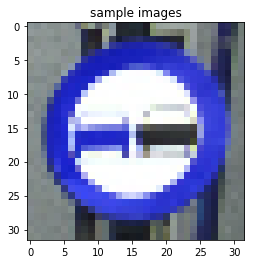

In [27]:
import matplotlib.pyplot as plt

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    
IMG_SHAPE = x_train[0].shape
plt.title('sample images')

show_image(x_test[7])



In [28]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2, 2, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [29]:
encoder,decoder = build_deep_autoencoder(IMG_SHAPE,code_size=512)

In [30]:
#autoencoder training

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 256)         295168    
__________

In [33]:
autoencoder.compile('nadam','mse')
autoencoder.fit(x=x_train,y=x_train,epochs=100,
                    validation_data=[x_test,x_test])

Train on 4575 samples, validate on 2520 samples
Epoch 1/100
4575/4575 [==============================] - 37s 8ms/step - loss: 0.0525 - val_loss: 0.0508
Epoch 2/100
4575/4575 [==============================] - 33s 7ms/step - loss: 0.0455 - val_loss: 0.0347
Epoch 3/100
4575/4575 [==============================] - 32s 7ms/step - loss: 0.0353 - val_loss: 0.0304
Epoch 4/100
4575/4575 [==============================] - 32s 7ms/step - loss: 0.0317 - val_loss: 0.0303
Epoch 5/100
4575/4575 [==============================] - 34s 7ms/step - loss: 0.0288 - val_loss: 0.0272
Epoch 6/100
4575/4575 [==============================] - 36s 8ms/step - loss: 0.0295 - val_loss: 0.0254
Epoch 7/100
4575/4575 [==============================] - 33s 7ms/step - loss: 0.0261 - val_loss: 0.0250
Epoch 8/100
4575/4575 [==============================] - 37s 8ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/100
4575/4575 [==============================] - 37s 8ms/step - loss: 0.0244 - val_loss: 0.0247
Epoch 10/100
457

4575/4575 [==============================] - 54s 12ms/step - loss: 0.0132 - val_loss: 0.0174
Epoch 79/100
4575/4575 [==============================] - 55s 12ms/step - loss: 0.0132 - val_loss: 0.0174
Epoch 80/100
4575/4575 [==============================] - 55s 12ms/step - loss: 0.0130 - val_loss: 0.0174
Epoch 81/100
4575/4575 [==============================] - 59s 13ms/step - loss: 0.0130 - val_loss: 0.0173
Epoch 82/100
4575/4575 [==============================] - 59s 13ms/step - loss: 0.0131 - val_loss: 0.0182
Epoch 83/100
4575/4575 [==============================] - 55s 12ms/step - loss: 0.0129 - val_loss: 0.0176
Epoch 84/100
4575/4575 [==============================] - 52s 11ms/step - loss: 0.0131 - val_loss: 0.0175
Epoch 85/100
4575/4575 [==============================] - 52s 11ms/step - loss: 0.0129 - val_loss: 0.0186
Epoch 86/100
4575/4575 [==============================] - 51s 11ms/step - loss: 0.0129 - val_loss: 0.0173
Epoch 87/100
4575/4575 [==============================] - 5

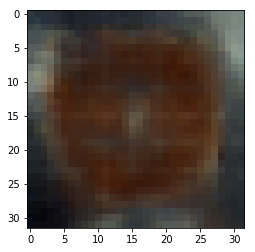

In [64]:
image = x_test[100]
code = encoder.predict(image[None])[0]
reconstructed = decoder.predict(code[None])[0]
show_image(reconstructed)

In [54]:
#Use this for end-to-end image segmentation/denoising.
images = x_train
codes=encoder.predict(x_train)

In [55]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)


def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

/Users/bedabratachoudhury/anaconda2/lib/python2.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [66]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

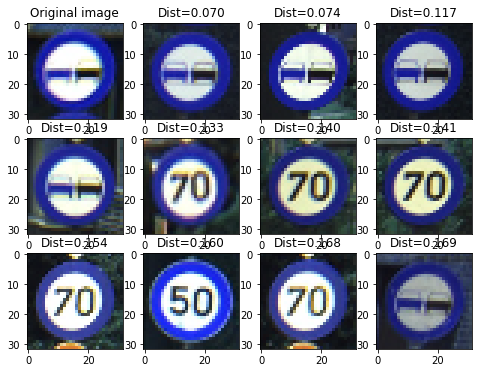

In [67]:
import matplotlib.pyplot as plt
show_similar(x_test[10])
plt.show()